In [4]:
#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) implementation.
Note: If you have found these software useful for your research, I would
appreciate an acknowledgment.
"""

__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

import numpy as NP
import matplotlib.pyplot as PLT


class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours

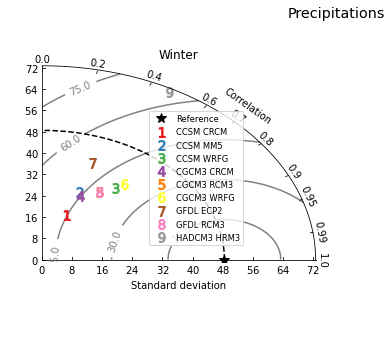

In [9]:
#!/usr/bin/env python

__version__ = "Time-stamp: <2018-12-06 11:55:22 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

"""
Example of use of TaylorDiagram. Illustration dataset courtesy of Michael
Rawlins.
Rawlins, M. A., R. S. Bradley, H. F. Diaz, 2012. Assessment of regional climate
model simulation estimates over the Northeast United States, Journal of
Geophysical Research (2012JGRD..11723112R).
"""

import numpy as NP
import matplotlib.pyplot as PLT

# Reference std
stdrefs = 48.491

# Sample std,rho: Be sure to check order and that correct numbers are placed!
samples = [[17.831, 0.360, "CCSM CRCM"],
                [27.062, 0.360, "CCSM MM5"],
                    [33.125, 0.585, "CCSM WRFG"],
                       [25.939, 0.385, "CGCM3 CRCM"],
                       [29.593, 0.509, "CGCM3 RCM3"],
                       [35.807, 0.609, "CGCM3 WRFG"],
                       [38.449, 0.342, "GFDL ECP2"],
                       [29.593, 0.509, "GFDL RCM3"],
                       [71.215, 0.473, "HADCM3 HRM3"]]

colors = PLT.matplotlib.cm.Set1(NP.linspace(0,1,len(samples)))

rects = dict(winter=221)

fig = PLT.figure(figsize=(11,8))
fig.suptitle("Precipitations", size='x-large')

dia = TaylorDiagram(stdrefs, fig=fig, rect=rects[season],
                        label='Reference')

# Add samples to Taylor diagram
for i,(stddev,corrcoef,name) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                    marker='$%d$' % (i+1), ms=10, ls='',
                    #mfc='k', mec='k', # B&W
                    mfc=colors[i], mec=colors[i], # Colors
                    label=name)

# Add RMS contours, and label them
contours = dia.add_contours(levels=5, colors='0.5') # 5 levels
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
# Tricky: ax is the polar ax (used for plots), _ax is the
# container (used for layout)
dia._ax.set_title(season.capitalize())

# Add a figure legend and title. For loc option, place x,y tuple inside [ ].
# Can also use special options here:
# http://matplotlib.sourceforge.net/users/legend_guide.html

fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, prop=dict(size='small'), loc='center')

fig.tight_layout()

PLT.savefig('test_taylor_4panel.png')
PLT.show()